# Introduction

In this notebook, we perform a local moran's I (LISA) analysis to assess local spatial autocorrelation in New York City eviction data. We identified clusters and outliers using both Rook and Queen contiguity methods.

The analysis reveals strong positive spatial autocorrelation, given moran's I 0.84 and a p-value of 0.001. This indicates that areas with high eviction rates tend to cluster together.

We then look into the clusters, which are classified into hh (high-high) hotspots, ll (low-low) coldspots, and lh/hl outliers.

We also visualized significant cluster with Folium maps, where p-values are less than 0.05. A total of 33,321 overlapping significant clusters were identified and overlapped with the two methods. These spatial patterns suggest geo concentrations of eviction activity, providing insights for policy makers. In the next notebooks with more focused hypothesis, we will explore landlord patterns and potential correlations between corporate landlords and high eviction clusters using the knowledge we have gained here.

In [2]:
# !pip install geopandas folium matplotlib seaborn scipy
# !pip install esda
# !pip install splot
# # for google colab, had to reinstall some pacakges.

In [ ]:
# !pip install geopandas folium matplotlib seaborn scipy esda splot

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime as dt
import scipy

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# visualization
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
import folium
from folium.plugins import HeatMap
from folium import Marker
from folium.plugins import MarkerCluster
import plotly.express as px
import plotly.io as pio

# spatial statistics
from esda.moran import Moran
from esda import Moran_Local
from esda.getisord import G_Local
from shapely.geometry import Point
from libpysal.weights import Queen, Rook

# system and utility
import warnings
import os
import io
from IPython.display import IFrame
from google.colab import files

from libpysal.weights import Queen, Rook
from esda.moran import Moran
import matplotlib.pyplot as plt
from splot.esda import moran_scatterplot

# suppress warnings
warnings.filterwarnings('ignore')

# inline
%matplotlib inline

# Part 1: Get the Eviction data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# data source:
# gdf already cleaned
file_path = '/content/drive/My Drive/X999/evictions_cleaned.csv'

In [6]:
evictions_cleaned_raw = pd.read_csv(file_path)

In [7]:
evictions_cleaned = evictions_cleaned_raw.copy()

# Part 4 Clustering Analysis

Add back some necessary code blocks here so things can continue. For more details, see previous notebooks.

In [8]:
attribute = evictions_cleaned['average_year_eviction_count'].values

In [9]:
# re-touch the data for further analysis
k = 3 # as decided by DBSCAN
evictions_cleaned['latitude'] = evictions_cleaned['latitude'].astype(float)
evictions_cleaned['longitude'] = evictions_cleaned['longitude'].astype(float)
evictions_cleaned['geometry'] = evictions_cleaned.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

## Part 4.2 Queen and Rook Contiguity

In [10]:
w_queen = Queen.from_dataframe(evictions_cleaned)
w_rook = Rook.from_dataframe(evictions_cleaned)

In [11]:
# still very good results
# use "average_year_eviction_count" column's values
attribute = evictions_cleaned['average_year_eviction_count'].values
moran_queen = Moran(attribute, w_queen)
print("moran's I with queen test:", moran_queen.I, "p-value:", moran_queen.p_sim)

moran's I with queen test: 0.8437983772474493 p-value: 0.001


In [12]:
# moran's I using Rook Contiguity
# also very good results
moran_rook = Moran(attribute, w_rook)
print("Moran's I with rook test:", moran_rook.I, "p-value (rook):", moran_rook.p_sim)

Moran's I with rook test: 0.8437989232536441 p-value (rook): 0.001


### What is happening here:

- Significant Clusters:

  -We filter the data to include only significant clusters, where the p-value is less than 0.05 for both Rook and Queen contiguity. This helps us compare the clusters identified by both spatial weight types.

- Cluster Labels:

  - Cluster labels (q) indicate the type of cluster found:
    - 1 = HH (High-High): High values surrounded by high values (hotspots).
    - 2 = LH (Low-High): Low values surrounded by high values (potential outliers).
    - 3 = LL (Low-Low): Low values surrounded by low values (coldspots).
    - 4 = HL (High-Low): High values surrounded by low values (potential outliers).

## Part 4.3 Local Moran's I Lisa Analysis

In [ ]:
# some lines of codes are repeatitive with the previous ones, but here we copy them
# so we can continue with the LISA analysis
# w_rook = Rook.from_dataframe(evictions_cleaned)
# need to reimport moran_local
lisa_rook = Moran_Local(attribute, w_rook)
# w_queen = Queen.from_dataframe(evictions_cleaned)
lisa_queen = Moran_Local(attribute, w_queen)

evictions_cleaned['lisa_cluster_rook'] = lisa_rook.q
evictions_cleaned['lisa_pvalue_rook'] = lisa_rook.p_sim
evictions_cleaned['lisa_cluster_queen'] = lisa_queen.q
evictions_cleaned['lisa_pvalue_queen'] = lisa_queen.p_sim


# only keep the most statistically significant ones
significant_clusters_rook = evictions_cleaned[evictions_cleaned['lisa_pvalue_rook'] < 0.05]
significant_clusters_queen = evictions_cleaned[evictions_cleaned['lisa_pvalue_queen'] < 0.05]

In [ ]:
print("significant clusters - rook contiguity is:")
significant_clusters_rook[['lisa_cluster_rook', 'lisa_pvalue_rook']].head()

significant clusters - rook contiguity is:


lisa_cluster_rook  lisa_pvalue_rook
7                   3             0.001
9                   3             0.026
10                  3             0.001
11                  1             0.001
12                  1             0.002

In [ ]:
print("significant clusters - queen contiguity is :")
significant_clusters_queen[['lisa_cluster_queen', 'lisa_pvalue_queen']].head()

significant clusters - queen contiguity is :


lisa_cluster_queen  lisa_pvalue_queen
7                    3              0.001
9                    3              0.025
10                   3              0.001
11                   1              0.001
12                   1              0.002

## Part 4.3 Clustering map vis/comparison

In [ ]:
# let's do rook first
map_lisa_rook = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# loop through the gdf and add markers based on Rook cluster results
for idx, row in evictions_cleaned.iterrows():
    lisa_cluster = row['lisa_cluster_rook']

    # assign colors based on LISA cluster types
    # high-high, good
    if lisa_cluster == 1:
        color = 'red'
    # lh
    elif lisa_cluster == 2:
        color = 'blue'
    # ll, good
    elif lisa_cluster == 3:
        color = 'green'
    # hl
    elif lisa_cluster == 4:
        color = 'orange'
    # the rest is not significant
    else:
        color = 'gray'

    # bring the marker to the map
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=6,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Rook LISA Cluster: {lisa_cluster}"
    ).add_to(map_lisa_rook)

In [ ]:
map_lisa_rook.save('lisa_rook_clusters_map.html')
map_lisa_rook

Saving lisa_rook_clusters_map.png to lisa_rook_clusters_map.png


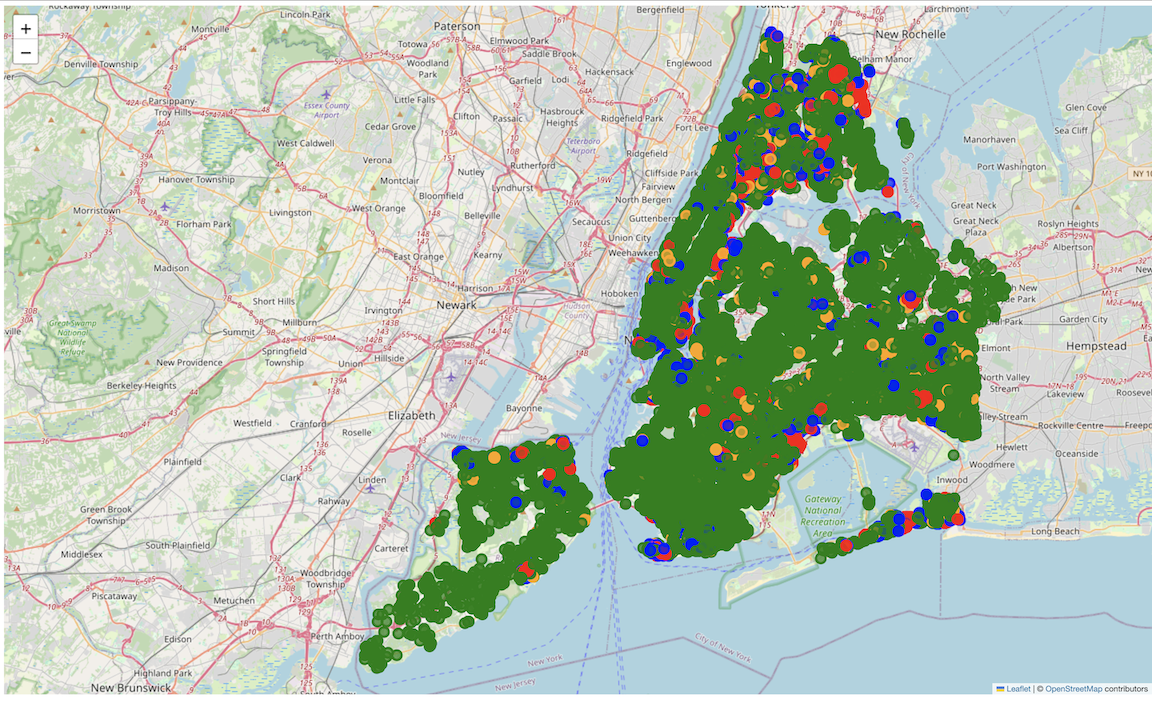

In [14]:
# lisa_rook_clusters_map.png
# in case it does not load, it is as shown below
from google.colab import files
from IPython.display import Image
uploaded = files.upload()
Image(filename='lisa_rook_clusters_map.png')

In [ ]:
# queen cluster reuslts in map
map_lisa_queen = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

for idx, row in evictions_cleaned.iterrows():
    lisa_cluster = row['lisa_cluster_queen']
    # hh good
    if lisa_cluster == 1:
        color = 'red'
    # lh
    elif lisa_cluster == 2:
        color = 'blue'
    # ll good
    elif lisa_cluster == 3:
        color = 'green'
    # hl
    elif lisa_cluster == 4:
        color = 'orange'
    # not significant
    else:
        color = 'gray'

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=6,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Queen LISA Cluster: {lisa_cluster}"
    ).add_to(map_lisa_queen)

In [ ]:
map_lisa_queen.save('lisa_queen_clusters_map.html')
map_lisa_queen

Saving lisa_queen_clusters_map.png to lisa_queen_clusters_map.png


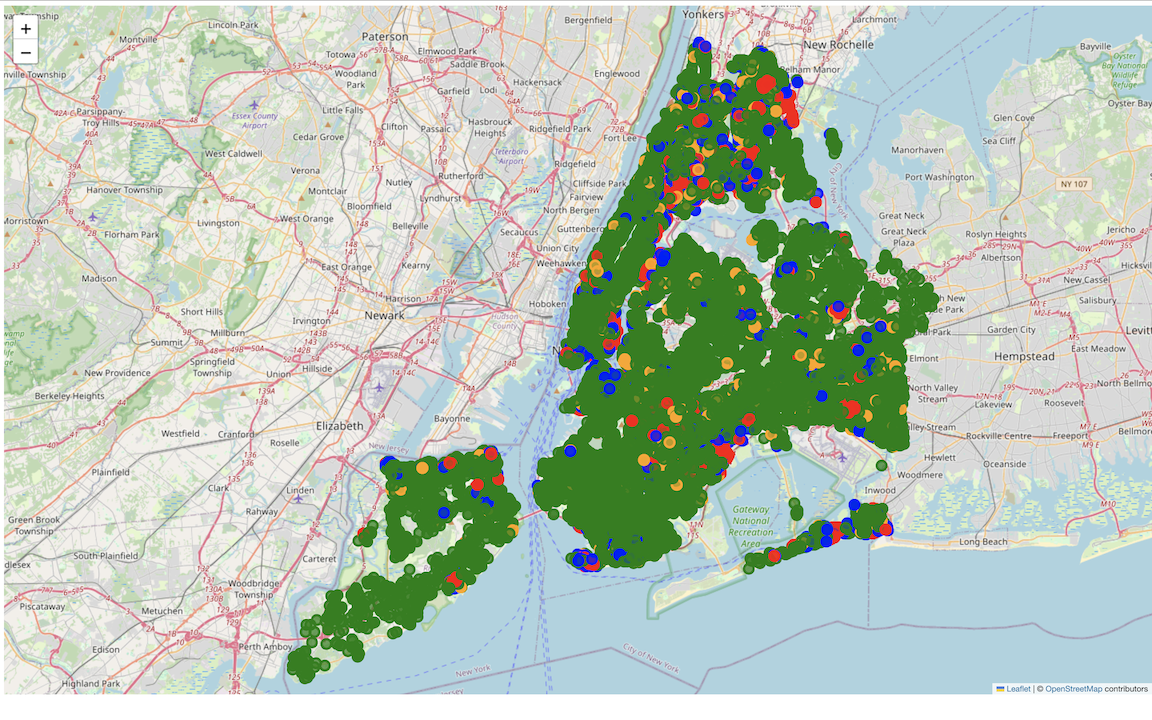

In [15]:
# lisa_queen_clusters_map.png
# in case it does not load, it is as shown below
from google.colab import files
from IPython.display import Image
uploaded = files.upload()
Image(filename='lisa_queen_clusters_map.png')

In [ ]:
# firstly, count the number of clusters for each type for Rook, categories: hh, lh, ll, hl
# secondly, count the number of clusters for each type for Queen

rook_cluster_counts = evictions_cleaned['lisa_cluster_rook'].value_counts().rename({
    1: 'HH (Rook)',
    2: 'LH (Rook)',
    3: 'LL (Rook)',
    4: 'HL (Rook)'
})
queen_cluster_counts = evictions_cleaned['lisa_cluster_queen'].value_counts().rename({
    1: 'HH (Queen)',
    2: 'LH (Queen)',
    3: 'LL (Queen)',
    4: 'HL (Queen)'
})

# better create a new df to compare the results:
rook_queen_comparison_df = pd.concat([rook_cluster_counts, queen_cluster_counts], axis=1)

In [ ]:
rook_queen_comparison_df.fillna(0)
# very similar results
# but we have not see the direct similarity and differences between rook and queen count

count    count
LL (Rook)   54469.0      0.0
HH (Rook)   11381.0      0.0
HL (Rook)    5643.0      0.0
LH (Rook)    4991.0      0.0
LL (Queen)      0.0  54468.0
HH (Queen)      0.0  11379.0
HL (Queen)      0.0   5645.0
LH (Queen)      0.0   4992.0

In [ ]:
# Find locations that are significant under both Rook and Queen
overlapping_clusters2 = evictions_cleaned[
    (evictions_cleaned['lisa_pvalue_rook'] < 0.05) &
    (evictions_cleaned['lisa_pvalue_queen'] < 0.05) &
    (evictions_cleaned['lisa_cluster_rook'] == evictions_cleaned['lisa_cluster_queen'])  # Same cluster type in both
]

# Display the overlapping clusters
print("number of overlapping clusters (same type in both Rook and Queen) are:", len(overlapping_clusters2))

number of overlapping clusters (same type in both Rook and Queen) are: 33321


In [ ]:
overlapping_clusters2[['lisa_cluster_rook', 'lisa_cluster_queen', 'lisa_pvalue_rook', 'lisa_pvalue_queen']]

lisa_cluster_rook  lisa_cluster_queen  lisa_pvalue_rook  \
7                      3                   3             0.001   
9                      3                   3             0.026   
10                     3                   3             0.001   
11                     1                   1             0.001   
12                     1                   1             0.008   
...                  ...                 ...               ...   
76478                  3                   3             0.001   
76479                  3                   3             0.001   
76480                  3                   3             0.001   
76482                  3                   3             0.007   
76483                  3                   3             0.001   

       lisa_pvalue_queen  
7                  0.001  
9                  0.013  
10                 0.001  
11                 0.001  
12                 0.003  
...                  ...  
76478              0.001  
76479              0.001  
76480              0.001  
76482              0.009  
76483              0.001  

[34203 rows x 4 columns]

In [ ]:
evictions_cleaned.lisa_pvalue_rook

0        0.241
1        0.201
2        0.058
3        0.052
4        0.431
         ...  
76479    0.001
76480    0.001
76481    0.160
76482    0.011
76483    0.001
Name: lisa_pvalue_rook, Length: 76484, dtype: float64

In [ ]:
evictions_cleaned.lisa_pvalue_rook

0        0.241
1        0.201
2        0.058
3        0.052
4        0.431
         ...  
76479    0.001
76480    0.001
76481    0.160
76482    0.011
76483    0.001
Name: lisa_pvalue_rook, Length: 76484, dtype: float64

In [ ]:
# overlapping_clusters2
# we visualize the differences here.
# create a map to visualize Rook, Queen, and overlapping clusters
map_comparison2 = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

for idx, row in evictions_cleaned.iterrows():
    # check the significance of Rook and Queen
    rook_sig = row['lisa_pvalue_rook'] < 0.05
    queen_sig = row['lisa_pvalue_queen'] < 0.05

    if rook_sig and queen_sig:
        color = 'purple'  # Overlapping significant clusters
        label = "Both Rook and Queen"
    elif rook_sig:
        color = 'red'  # Significant in Rook only
        label = "Rook Only"
    elif queen_sig:
        color = 'blue'  # Significant in Queen only
        label = "Queen Only"
    else:
        color = 'gray'  # Non-significant

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=6,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Cluster: {label}"
    ).add_to(map_comparison2)


In [ ]:
map_comparison2.save('map_comparison2.html')
map_comparison2

Saving diff_map_comparison2.png to diff_map_comparison2.png


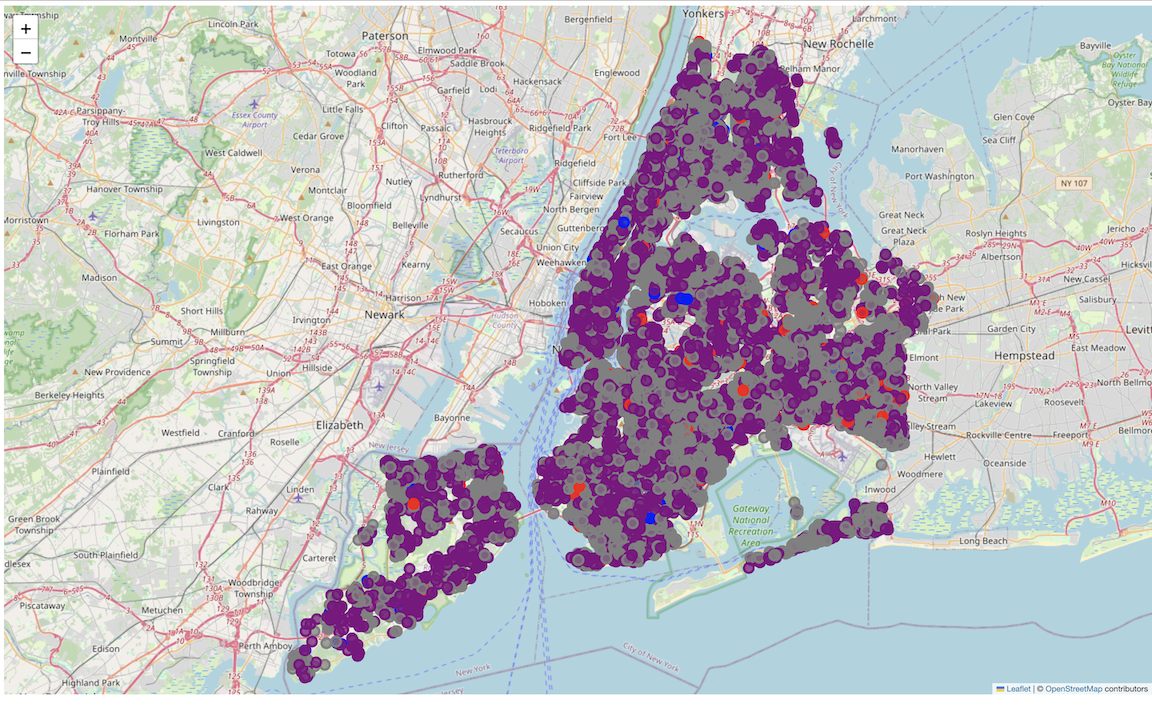

In [16]:
from google.colab import files
from IPython.display import Image
uploaded = files.upload()
Image(filename='diff_map_comparison2.png')

In [ ]:
print(f"Moran's I (Rook): {moran_rook.I}, p-value (Rook): {moran_rook.p_sim}")
print(f"Moran's I (Queen): {moran_queen.I}, p-value (Queen): {moran_queen.p_sim}")

Moran's I (Rook): 0.8437989232536441, p-value (Rook): 0.001
Moran's I (Queen): 0.8437983772474493, p-value (Queen): 0.001


In [ ]:
# significant clusters, meaning where p-value < 0.05
significant_rook = evictions_cleaned[evictions_cleaned['lisa_pvalue_rook'] < 0.05]
significant_queen = evictions_cleaned[evictions_cleaned['lisa_pvalue_queen'] < 0.05]

# check for overlap between the two sets of significant clusters
overlapping_clusters = significant_rook[significant_rook.index.isin(significant_queen.index)]

# count the number of overlapping significant clusters
print(f"Number of overlapping significant clusters: {len(overlapping_clusters)}")

Number of overlapping significant clusters: 33321


In [ ]:
evictions_cleaned.shape, significant_rook.shape, significant_queen.shape

((76484, 28), (33856, 28), (34600, 28))

In [ ]:
# display the overlapping clusters' attributes for further analysis
overlapping_clusters[['lisa_cluster_rook', 'lisa_cluster_queen', 'lisa_pvalue_rook', 'lisa_pvalue_queen']]

lisa_cluster_rook  lisa_cluster_queen  lisa_pvalue_rook  \
7                      3                   3             0.001   
9                      3                   3             0.026   
10                     3                   3             0.001   
11                     1                   1             0.001   
12                     1                   1             0.002   
...                  ...                 ...               ...   
76478                  3                   3             0.001   
76479                  3                   3             0.001   
76480                  3                   3             0.001   
76482                  3                   3             0.011   
76483                  3                   3             0.001   

       lisa_pvalue_queen  
7                  0.001  
9                  0.025  
10                 0.001  
11                 0.001  
12                 0.002  
...                  ...  
76478              0.001  
76479              0.001  
76480              0.001  
76482              0.005  
76483              0.001  

[33321 rows x 4 columns]

#### short summary:

- we compared the number of each cluster type (HH, LH, LL, HL) between Rook and Queen contiguity. (tabular comparisons)
- we compared the overall spatial autocorrelation strength using Moran’s I values for both methods (rook and queen).
- we quantified locations that are consistently identified as clusters under both Rook and Queen contiguity.
- we visualized overlapping clusters on a single map for spatial comparison without the need to store multiple maps.

In [ ]:
# using overlapping clusters dataframe here to show overlapped significant clusters on
# folium map to beter visualize and understand the clusters
map_overlapping_clusters = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# loop through the overlapping clusters and mark them
for idx, row in overlapping_clusters.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=6,
        # use a different color for overlapping clusters
        color='purple',
        fill=True,
        fill_color='purple',
        fill_opacity=0.7,
        popup=f"Rook Cluster: {row['lisa_cluster_rook']}, Queen Cluster: {row['lisa_cluster_queen']}"
    ).add_to(map_overlapping_clusters)

In [ ]:
# save and display
map_overlapping_clusters.save('overlapping_clusters_map.html')
map_overlapping_clusters

Saving overlaping_clusters_map.png to overlaping_clusters_map.png


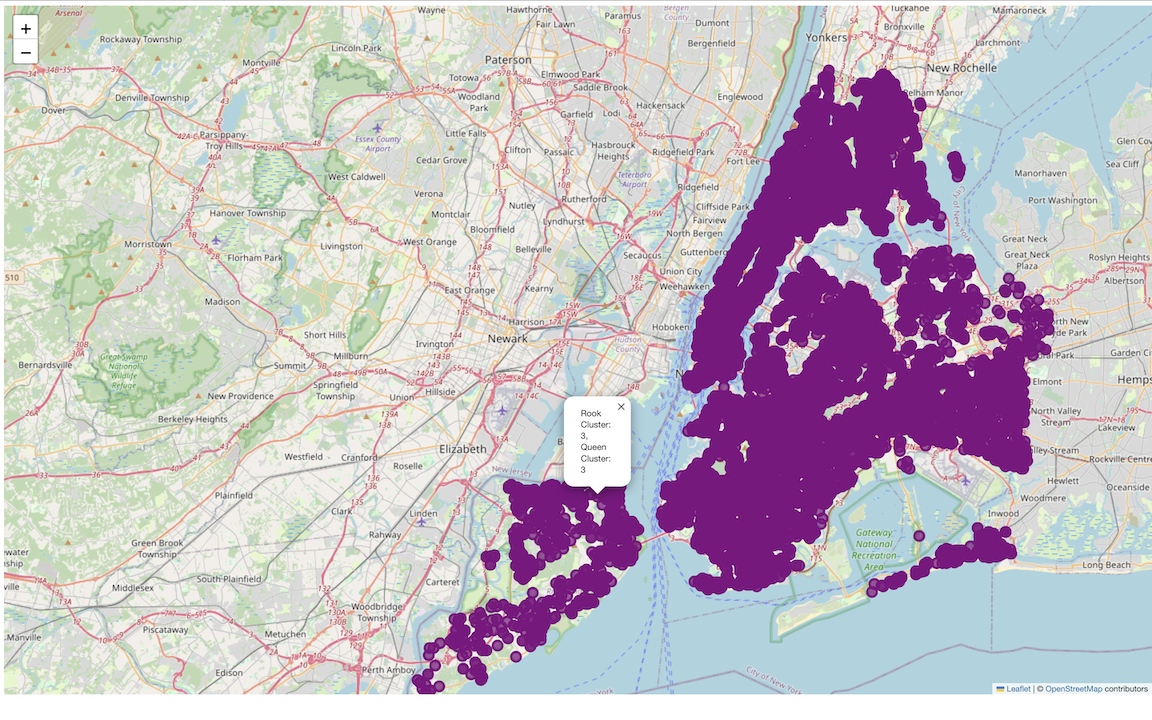

In [17]:
# lisa_queen_clusters_map.png
# in case it does not load, it is as shown below
from google.colab import files
from IPython.display import Image
uploaded = files.upload()
Image(filename='overlaping_clusters_map.png')

### TODO 2:
#### These will be realized in a different notebook due to readability and size concerns, with a more targted and focused analysis of the eviction data.
### Some actionables/research questions/hypothesis include:
    - locate high eviction clusters using K-Means or DBSCAN.
    - merge the eviction data with building info from the bbl.csv
    - analyze landlord patterns to see which landlords (such as corporate vs. individual) are responsible for high eviction rates with the data from bbl.
    - test hypothesis that corporate landlords are more likely to be involved in high eviction clusters using statistical methods.
    - visualize and map the results with much sparse data to highlight eviction hotspos and buildings.
    
    
All these will be included in the next notebooks

In [ ]:
evictions_cleaned.columns

Index(['court_index_number', 'docket_number', 'eviction_address',
       'eviction_apartment_number', 'executed_date', 'borough',
       'eviction_postcode', 'ejectment', 'eviction/legal_possession',
       'latitude', 'longitude', 'community_board', 'council_district',
       'census_tract', 'bin', 'bbl', 'nta', 'geometry', 'eviction_count',
       'year', 'average_year_eviction_count', 'cluster', 'cluster_k',
       'same_cluster', 'lisa_cluster_rook', 'lisa_pvalue_rook',
       'lisa_cluster_queen', 'lisa_pvalue_queen'],
      dtype='object')

In [ ]:
# save the most updated eviction_cleaned to google drive
evictions_cleaned.to_csv('/content/drive/My Drive/X999/evictions_cleaned_lisa.csv', index=False)